<h2>Imports</h2>

In [1]:
%matplotlib inline

/Users/emiwang/.virtualenvs/note/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from __future__ import absolute_import
import os
import random
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

DATA_DIR = '/Users/emiwang/Learning/notebooks/data/'
BASE_FILE = 'meps_base_data.csv'
MEDS_FILE = 'meps_meds.csv'

plt.style.use('ggplot')

<h2>Functions</h2>

<h2>Exploring the datasets</h2>

In [3]:
base_data = pd.read_csv(os.path.join(DATA_DIR, BASE_FILE))
meds_data = pd.read_csv(os.path.join(DATA_DIR, MEDS_FILE))

<h3>Base data</h3>

In [4]:
# There are ages of -1?  No data?  What is pooledWeight and what are the units?
base_data[['panel', 'pooledWeight', 'age']].describe()

,panel,pooledWeight,age
count,61489.000000,61489.000000,61489.000000
mean,13.534453,5063.701982,33.578396
std,1.061329,3815.885387,22.887576
min,12.000000,127.710358,-1.000000
25%,13.000000,2217.419038,14.000000
50%,14.000000,3989.180418,32.000000
75%,14.000000,6905.677619,51.000000
max,15.000000,38828.153564,85.000000


In [5]:
pd.get_dummies(base_data.panel)[:1]  # There are 4 panels; perhaps this data consists of 4 surveys.

,12,13,14,15
0,0.0,0.0,0.0,1.0


In [6]:
100 * float(base_data[base_data.age==-1].count().id) / len(base_data)  # 2.8% of entries have no valid age

2.777732602579323

In [7]:
len(base_data), len(base_data.drop_duplicates())  # No completely duplicate entries

(61489, 61489)

In [8]:
# Remove the unnamed index, id, and panel columns
subset_cols = [i for i in base_data.columns if i not in ('Unnamed: 0', 'id', 'panel')]
# Check for duplicates: less than 1% are duplicated
len(base_data), len(base_data.drop_duplicates(subset=subset_cols))

(61489, 61315)

In [9]:
subset_base_data = base_data.copy(deep=True)
subset_base_data = subset_base_data[subset_cols]
subset_base_data['entry_count'] = 1

In [10]:
dupe_count = subset_base_data.groupby(subset_cols).count()
# dupe_count[dupe_count.entry_count > 1].head()

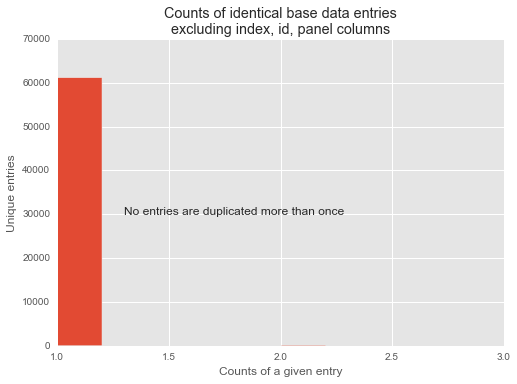

In [14]:
dupe_count.entry_count.hist(bins=10)
plt.title('Counts of identical base data entries\nexcluding index, id, panel columns')
plt.xlabel('Counts of a given entry')
plt.ylabel('Unique entries')
plt.text(1.3, 30000, 'No entries are duplicated more than once', fontsize=12)

In [15]:
base_data.head()  # If people are under 16 they can't be married?  Or question is omitted if patient under 16?

,Unnamed: 0,id,panel,pooledWeight,age,sex,race,married,highBPDiagnosed,diabetesDiagnosed,chdDiagnosed,miDiagnosed,anginaDiagnosed,strokeDiagnosed,emphysemaDiagnosed,asthmaDiagnosed,otherHDDiagnosed,heartFailureDiagnosed
0,1,10007101,15,3603.881236,28,Male,White,MARRIED,Yes,No,No,No,No,No,No,No,No,No
1,2,10007102,15,2544.550424,25,Female,White,MARRIED,No,No,No,No,No,No,No,Yes,No,No
2,3,10007103,15,4050.397468,4,Male,White,UNDER 16 - INAPPLICABLE,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,No,Inapplicable,No
3,4,10007104,15,3064.059720,3,Female,White,UNDER 16 - INAPPLICABLE,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,No,Inapplicable,No
4,5,10008101,15,3635.552466,51,Male,Multiple,MARRIED,No,No,No,No,No,No,No,No,No,No


In [16]:
base_copy = base_data.copy(deep=True)

In [17]:
# Looking at frequencies for categorical variables
base_copy['entry_count'] = 1
cat_cols = [i for i in base_data.columns if i not in ('Unnamed: 0', 'id', 'panel', 'age', 'pooledWeight')]
for column in cat_cols:
    print base_copy.groupby(column).count()[['entry_count']]

        entry_count
sex                
Female        32075
Male          29414
                                  entry_count
race                                         
Amer Indian/Alaska Native                 623
Asian                                    4080
Black                                   12325
Multiple                                 1358
Native Hawaiian/Pacific Islander          234
White                                   42869
                         entry_count
married                             
DIVORCED                        3196
DIVORCED IN ROUND               1238
INAPPLICABLE                    1708
MARRIED                        21424
MARRIED IN ROUND                1021
NEVER MARRIED                  13435
SEPARATED                        672
SEPARATED IN ROUND               615
UNDER 16 - INAPPLICABLE        15515
WIDOWED                         2294
WIDOWED IN ROUND                 371
                 entry_count
highBPDiagnosed             
DK           

In [18]:
base_dummy_cols = cat_cols + ['id']
cat_prep = pd.get_dummies(base_copy[base_dummy_cols])  # Process categorical variables
cat_prep[0:1]

,id,sex_Female,sex_Male,race_Amer Indian/Alaska Native,race_Asian,race_Black,race_Multiple,race_Native Hawaiian/Pacific Islander,race_White,married_DIVORCED,...,asthmaDiagnosed_Yes,asthmaDiagnosed_not ascertained,otherHDDiagnosed_DK,otherHDDiagnosed_Inapplicable,otherHDDiagnosed_No,otherHDDiagnosed_Refused,otherHDDiagnosed_Yes,otherHDDiagnosed_not ascertained,heartFailureDiagnosed_No,heartFailureDiagnosed_Yes
0,10007101,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [19]:
len(cat_prep), len(base_copy)

(61489, 61489)

<h3>Prescribed meds data</h3>

In [20]:
meds_data.head()

,Unnamed: 0,id,rxStartMonth,rxStartYear,rxName,rxNDC,rxQuantity,rxForm
0,1,10007104,3,2011,AMOXICILLIN,143988775,75.0,SUSR
1,2,10007104,3,2011,OTIC EDGE SOLUTION,68032032814,14.0,SOL
2,3,10008102,3,2011,NASAL DECONGESTANT 0.05% SPRAY,63981056903,15.0,SPR
3,4,10008102,3,2011,NASAL DECONGESTANT 0.05% SPRAY,63981056903,15.0,SPR
4,5,10008102,9,2011,DIPHENHYDRAM,603333921,30.0,CAP


In [21]:
len(meds_data), len(meds_data.drop_duplicates())  # Also no completely duplicate rows here

(1148347, 1148347)

There are a lot of different rxNames.  Maybe some are named by chemical name and others are named by brand name.  And some could just be duped because of spacing or spelling.  How specific are these?  For instance, "Nasal Decongestant" seems rather vague.

In [22]:
len(meds_data.rxName.unique()), len(meds_data.rxNDC.unique()), len(meds_data.rxForm.unique())

(9218, 28736, 328)

A quick look at sorted names already reveals some obvious duplicates, e.g. ' HYDROCHLOROTHIAZIDE (HCTZ)' vs. ' HYDROCHLOROTHIZAIDE'.  That number in front of some meds seems like it is a category code.

In [23]:
sorted(list(meds_data.rxName.unique()))[0:20]

[' CLOPIDOGREL',
 ' HYDROCHLOROTHIAZIDE (HCTZ)',
 ' HYDROCHLOROTHIZAIDE',
 ' LIPITOR',
 '(ARMOUR) THYROID (1GR)',
 '-9',
 '1 ANTI-INFECTIVES',
 '1.5 INCH 27 GAUGE NEEDLE',
 '1/2ML TB SYR',
 '10',
 '105 MISCELLANEOUS AGENTS',
 '113 GENITOURINARY TRACT AGENTS',
 '115 NUTRITIONAL PRODUCTS',
 '122 RESPIRATORY AGENTS',
 '133 TOPICAL AGENTS',
 '1CC TB SYRNG27GX1/2"',
 '1ML TB SYRNG',
 '20 ANTINEOPLASTICS',
 '218 ALTERNATIVE MEDICINES',
 '242 PSYCHOTHERAPEUTIC AGENTS']

Looking at specific drug strings to understand the duping situation.  There are punctuation variations for drug combinations, so we should treat the &, AND, -, and / situations as equivalent.  Possibly eliminate things in parentheses, since they tend to be commentary on the form of the prescription.

In [24]:
zyp_set = set([i for i in meds_data.rxName if 'ZYPREXA' in i])
zyp_set

{'ZYPREXA',
 'ZYPREXA (IDENTI-DOSE)',
 'ZYPREXA 10MG',
 'ZYPREXA 15MG',
 'ZYPREXA ZYDI',
 'ZYPREXA ZYDIS',
 'ZYPREXA ZYDIS (DOSE PACK)'}

In [25]:
hctz_set = set([i for i in meds_data.rxName if 'HYDROCHLOROTHIAZIDE' in i])
hctz_set

{' HYDROCHLOROTHIAZIDE (HCTZ)',
 'AMILORIDE HCL-HYDROCHLOROTHIAZIDE',
 'BENAZEPRIL HCL/HYDROCHLOROTHIAZIDE',
 'BENAZEPRIL HCL/HYDROCHLOROTHIAZIDE (FILM-COATED)',
 'BENAZEPRIL-HYDROCHLOROTHIAZIDE',
 'BISOPROLOL & HYDROCHLOROTHIAZIDE',
 'BISOPROLOL-HYDROCHLOROTHIAZIDE',
 'CAPTOPRIL-HYDROCHLOROTHIAZIDE',
 'ENALAPRIL-HYDROCHLOROTHIAZIDE',
 'ENALPRIL/HYDROCHLOROTHIAZIDE',
 'FOSINOPRIL-HYDROCHLOROTHIAZIDE',
 'HYDROCHLOROTHIAZIDE',
 'HYDROCHLOROTHIAZIDE (HARD GELATIN)',
 'HYDROCHLOROTHIAZIDE (HCTZ)',
 'HYDROCHLOROTHIAZIDE (UNIT OF USE)',
 'HYDROCHLOROTHIAZIDE (USP)',
 'HYDROCHLOROTHIAZIDE 25 MG',
 'HYDROCHLOROTHIAZIDE 25 MG TABLET',
 'HYDROCHLOROTHIAZIDE-LISINOPRIL',
 'HYDROCHLOROTHIAZIDE-METOPROLOL',
 'HYDROCHLOROTHIAZIDE-MOEXIPRIL HYDROCHLORIDE',
 'HYDROCHLOROTHIAZIDE-PO 25MG TAB',
 'HYDROCHLOROTHIAZIDE-PROPRANOLOL',
 'HYDROCHLOROTHIAZIDE-QUINAPRIL HYDROCHLORIDE',
 'HYDROCHLOROTHIAZIDE-SPIRONOLACTONE',
 'HYDROCHLOROTHIAZIDE-TRIAMTERENE',
 'HYDROCHLOROTHIAZIDE/LISINOPRIL',
 'HYDROCHLOROTHIAZ

In [26]:
list(set([i for i in meds_data.rxName if 'HCTZ' in i]))[0:10]  # Abbreviations also cause duping.  Ignore for now.

['TRIAMT/HCTZ',
 'BISOPRL/HCTZ',
 'TRIMT/HCTZ',
 'ENALAPR/HCTZ',
 'MAXZIDE-25 <HCTZ/TRIAM>',
 'TRAIMTERENE/HCTZ',
 'LISINO-HCTZ',
 'LISINOP /HCTZ',
 'BISOPROLOL/HCTZ (10X10)',
 'LOSARTAN-HCTZ']

In [27]:
[i for i in meds_data.rxName if '<' in i or '>' in i][0:10]  # Brand names and chemical abbreviations

['VICODIN <HYDROCOD/APAP>',
 'VICODIN <HYDROCOD/APAP>',
 'VICODIN <HYDROCOD/APAP>',
 'VICODIN <HYDROCOD/APAP>',
 'VICODIN <HYDROCOD/APAP>',
 'VICODIN <HYDROCOD/APAP>',
 'MAXZIDE-25 <HCTZ/TRIAM>',
 'MAXZIDE-25 <HCTZ/TRIAM>']

In [28]:
# But sometimes the brand names don't include chemical names.  Ignore for now.
set([i for i in meds_data.rxName if 'VICODIN' in i])

{'VICODIN',
 'VICODIN 5 MG/500 MG',
 'VICODIN <HYDROCOD/APAP>',
 'VICODIN EQUIV',
 'VICODIN ES',
 'VICODIN ES (R.N.P.,4X25)',
 'VICODIN HP',
 'VICODIN TUSS EXPECTORANT (AF,SF,DYE-FREE,CHERRY)',
 'VICODIN/EQUIV'}

In [29]:
meds_copy = meds_data.copy(deep=True)

In [30]:
meds_copy.columns

Index([u'Unnamed: 0', u'id', u'rxStartMonth', u'rxStartYear', u'rxName',
       u'rxNDC', u'rxQuantity', u'rxForm'],
      dtype='object')

In [31]:
def clean_rxname(rxname):
    """Make string substitutions to dedupe rxnames.
    
    Remove all parenthetical statements.
    Replace ' AND ', '/', ' & ' with '-'.
    Strip trailing and leading spaces.

    """
    replacements = [
        ('\([\w\s\D]+\)', ''),
        (' AND ', '-'),
        (' & ', '-'),
        ('/', '-')
    ]
    for pattern in replacements:
        rxname = re.sub(pattern[0], pattern[1], rxname)
    rxname = rxname.rstrip().lstrip()
    return rxname

In [32]:
clean_rxname(' HYDROCHLOROTHIAZIDE AND MEEP & RAINBOW/CHARMS (FILM-COATED 22 MG)')

'HYDROCHLOROTHIAZIDE-MEEP-RAINBOW-CHARMS'

In [33]:
hctz_clean = [clean_rxname(i) for i in hctz_set]
set(hctz_clean)

{'AMILORIDE HCL-HYDROCHLOROTHIAZIDE',
 'BENAZEPRIL HCL-HYDROCHLOROTHIAZIDE',
 'BENAZEPRIL-HYDROCHLOROTHIAZIDE',
 'BISOPROLOL-HYDROCHLOROTHIAZIDE',
 'CAPTOPRIL-HYDROCHLOROTHIAZIDE',
 'ENALAPRIL-HYDROCHLOROTHIAZIDE',
 'ENALPRIL-HYDROCHLOROTHIAZIDE',
 'FOSINOPRIL-HYDROCHLOROTHIAZIDE',
 'HYDROCHLOROTHIAZIDE',
 'HYDROCHLOROTHIAZIDE 25 MG',
 'HYDROCHLOROTHIAZIDE 25 MG TABLET',
 'HYDROCHLOROTHIAZIDE-LISINOPRIL',
 'HYDROCHLOROTHIAZIDE-METOPROLOL',
 'HYDROCHLOROTHIAZIDE-MOEXIPRIL HYDROCHLORIDE',
 'HYDROCHLOROTHIAZIDE-PO 25MG TAB',
 'HYDROCHLOROTHIAZIDE-PROPRANOLOL',
 'HYDROCHLOROTHIAZIDE-QUINAPRIL HYDROCHLORIDE',
 'HYDROCHLOROTHIAZIDE-SPIRONOLACTONE',
 'HYDROCHLOROTHIAZIDE-TRIAMTERENE',
 'LISINOPRIL-HYDROCHLOROTHIAZIDE',
 'LOSARTAN POTASSIUM-HYDROCHLOROTHIAZIDE',
 'QUINAPRIL-HYDROCHLOROTHIAZIDE',
 'SPIRONOLACTONE-HYDROCHLOROTHIAZIDE',
 'TRIAMTERENE-HYDROCHLOROTHIAZIDE',
 'VALSARTAN-HYDROCHLOROTHIAZIDE'}

In [34]:
rxnames = meds_copy.rxName
rxnames_clean = [clean_rxname(i) for i in rxnames]

In [35]:
len(set(rxnames_clean)), len(rxnames)

(7628, 1148347)

<h2>Data preparation</h2>

Based on above exploration, let's remove duplicate rows from base data.

In [36]:
base_clean = base_copy.drop_duplicates(subset=subset_cols)

In [37]:
meds_dedup_cols = [i for i in meds_data.columns if i not in ('Unnamed: 0')]
len(meds_data), len(meds_data.drop_duplicates(subset=meds_dedup_cols))

(1148347, 377386)

In [38]:
meds_dedup_cols = [i for i in meds_data.columns if i not in ('Unnamed: 0', 'id')]
len(meds_data), len(meds_data.drop_duplicates(subset=meds_dedup_cols))

(1148347, 264411)

We could have duplicate client info who nevertheless have different prescription info.

<h2>Initial questions</h2>

1. What are the most common medications for each disease in the base file?
2. What medications are most indicative of each disease?

In [39]:
# For each disease, see the distribution of medications?  Top 10 medications?
# Join the medications on to the disease data
# Try deduping people?

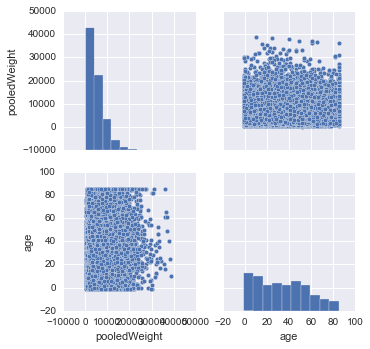

In [40]:
sns.set()

#df = sns.load_dataset("iris")
#sns.pairplot(df, hue="species")

df = base_copy[['pooledWeight', 'age']]
sns.pairplot(df)

In [41]:
base_copy.columns

Index([u'Unnamed: 0', u'id', u'panel', u'pooledWeight', u'age', u'sex',
       u'race', u'married', u'highBPDiagnosed', u'diabetesDiagnosed',
       u'chdDiagnosed', u'miDiagnosed', u'anginaDiagnosed', u'strokeDiagnosed',
       u'emphysemaDiagnosed', u'asthmaDiagnosed', u'otherHDDiagnosed',
       u'heartFailureDiagnosed', u'entry_count'],
      dtype='object')

In [42]:
chd_dummies = pd.get_dummies(base_copy.chdDiagnosed, prefix='chdDiagnosed')
sns_test = pd.merge(chd_dummies, base_copy[['id', 'panel', 'pooledWeight', 'age']], left_index=True, right_index=True)

In [43]:
len(chd_dummies), len(sns_test), len(base_copy)

(61489, 61489, 61489)

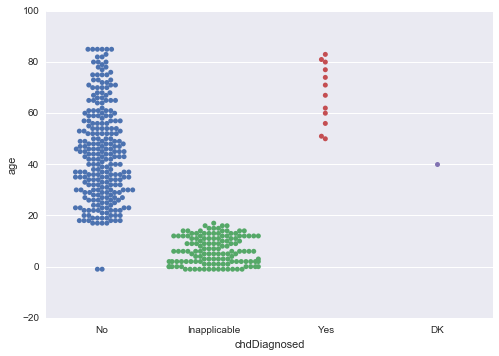

In [44]:
sns.swarmplot(x='chdDiagnosed', y='age', data=base_copy.sample(400))

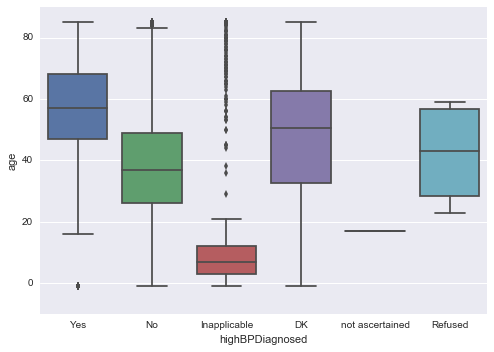

In [45]:
sns.boxplot(x='highBPDiagnosed', y='age', data=base_copy)

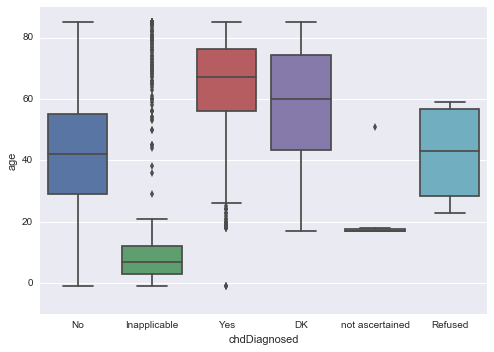

In [46]:
sns.boxplot(x='chdDiagnosed', y='age', data=base_copy)

In [47]:
base_copy.chdDiagnosed.unique()

array(['No', 'Inapplicable', 'Yes', 'DK', 'not ascertained', 'Refused'], dtype=object)

<h2>Building the model</h2>

We want a multi-class classifier to take as input the medications prescribed and give as output what diseases a patient has.  We must demonstrate that the end user should be confident in the result.